In [47]:

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [48]:
# Load and preprocess the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define the features and target
features = ['Adj Close', 'Open', 'High', 'Low', 'Volume', 'ATR', 'ADX', 'RSI', 
            'MACD', 'MACD_Signal', 'Volatility', 'Max_Drawdown']
target = 'Adj Close'

# Create lagged features
def create_lagged_features(data, lag=30):
    """
    Generate lagged features for all columns in the dataset for time series prediction.
    """
    lagged_frames = [data]  # Start with the original dataset
    for i in range(1, lag + 1):
        # Shift all columns in the dataset to create lagged features
        lagged_frame = data.shift(i).add_suffix(f'_Lag_{i}')
        lagged_frames.append(lagged_frame)
    
    # Combine all lagged dataframes
    df_lagged = pd.concat(lagged_frames, axis=1)
    df_lagged.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return df_lagged

# Apply lagged features
lagged_df = create_lagged_features(df[features], lag=30)

# Prepare data for modeling
X = lagged_df.drop(columns=['Adj Close'])  # Exclude 'Adj Close' from features
y = lagged_df['Adj Close']  # Target is the 'Adj Close'

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [49]:
# Time Series Cross-Validation 
tscv = TimeSeriesSplit(n_splits=5)
# Initialize Lasso Regression (L1 Regularization)
lasso_model = Lasso(alpha=0.1, max_iter=5000)

In [50]:
mae, rmse, r2 = [], [], []
fold = 1

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Ridge Regression
    lasso_model.fit(X_train, y_train)
    lasso_pred = lasso_model.predict(X_test)
    mae.append(mean_absolute_error(y_test, lasso_pred))
    rmse.append(np.sqrt(mean_squared_error(y_test, lasso_pred)))
    r2.append(r2_score(y_test, lasso_pred))

    print(f'Fold {fold} - MAE: {mae[-1]:.2f}, RMSE: {rmse[-1]:.2f}, R2: {r2[-1]:.2f}')
    fold += 1

print("\nCross-Validation Results (Average):")
print(f'MAE: {np.mean(mae):.2f}')
print(f'RMSE: {np.mean(rmse):.2f}')
print(f'R2: {np.mean(r2):.2f}')

Fold 1 - MAE: 3.42, RMSE: 4.74, R2: 1.00
Fold 2 - MAE: 5.64, RMSE: 8.28, R2: 1.00
Fold 3 - MAE: 7.75, RMSE: 9.55, R2: 1.00
Fold 4 - MAE: 9.50, RMSE: 11.40, R2: 1.00
Fold 5 - MAE: 15.89, RMSE: 21.96, R2: 1.00

Cross-Validation Results (Average):
MAE: 8.44
RMSE: 11.19
R2: 1.00


In [51]:
# Train-test split for final evaluation
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train the Lasso model
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

# Convert to NumPy arrays for consistency
y_test = np.array(y_test)
lasso_pred = np.array(lasso_pred)

# Final evaluation metrics
mae = mean_absolute_error(y_test, lasso_pred)
rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
r2 = r2_score(y_test, lasso_pred)

# Accuracy within 0.5% error
lasso_accuracy = np.abs((lasso_pred - y_test) / y_test) <= 0.005
lasso_accuracy_rate = np.mean(lasso_accuracy) * 100

# Directional Accuracy
actual_direction = np.diff(y_test) > 0  # True if the actual value goes up
predicted_direction = np.diff(lasso_pred) > 0  # True if the predicted value goes up
directional_accuracy = np.mean(actual_direction == predicted_direction) * 100

# Print results
print("\nFinal Evaluation:")
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'Accuracy within 0.5%: {lasso_accuracy_rate:.2f}%')
print(f'Directional Accuracy: {directional_accuracy:.2f}%')



Final Evaluation:
MAE: 14.46
RMSE: 19.95
R2: 1.00
Accuracy within 0.5%: 74.66%
Directional Accuracy: 80.70%


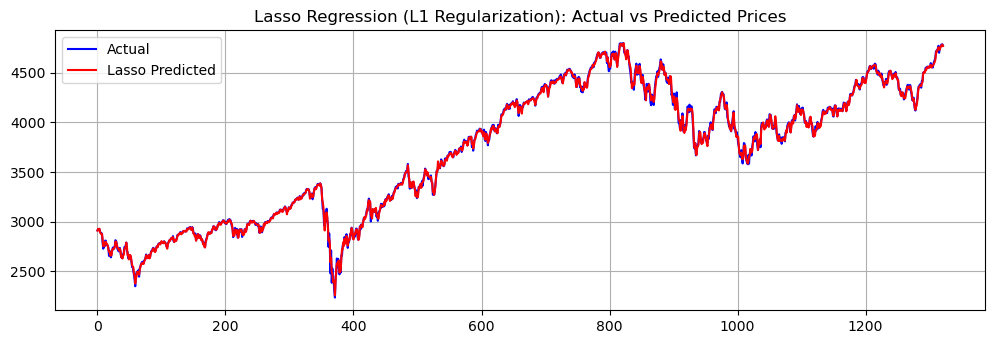

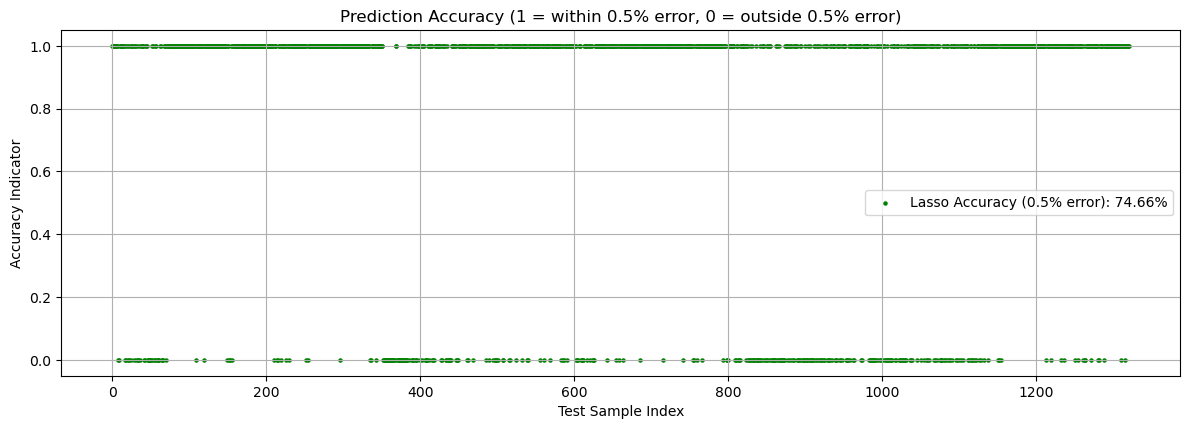

In [52]:
# Visualization
plt.figure(figsize=(12, 8))

# Lasso Regression: Actual vs Predicted
plt.subplot(2, 1, 1)
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue')
plt.plot(range(len(lasso_pred)), lasso_pred, label='Lasso Predicted', color='red')
plt.title(f'Lasso Regression (L1 Regularization): Actual vs Predicted Prices')
plt.legend()
plt.grid(True)

# 0.5% Error Accuracy
lasso_accuracy_plot = [1 if abs((p - a) / a) <= 0.005 else 0 for p, a in zip(lasso_pred, y_test)]
lasso_accuracy_rate = sum(lasso_accuracy_plot) / len(lasso_accuracy_plot) * 100

# Plot the prediction accuracy
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 2)
plt.scatter(
    range(len(lasso_accuracy_plot)), 
    lasso_accuracy_plot, 
    label=f'Lasso Accuracy (0.5% error): {lasso_accuracy_rate:.2f}%', 
    color='green', s=5
)

# Add title, legend, and grid
plt.title('Prediction Accuracy (1 = within 0.5% error, 0 = outside 0.5% error)')
plt.xlabel('Test Sample Index')
plt.ylabel('Accuracy Indicator')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
